In [1]:
import numpy as np
import scipy.optimize as so
import scipy.stats as ss
import utm
import datetime as dt
import time
import matplotlib.pyplot as plt
from matplotlib.patches import Circle


In [2]:
zoneNum = 'S'
zone = 11
useModeledDatapoints = True
dataPoints = [
#     easting, northing, alt, RSSI
    [373634, 4930271, 30, 60],
    [373624, 4930281, 30, 50],
    [373634, 4930291, 30, 40],
    [373654, 4930271, 30, 30]
]
txLocation = [373636, 4930279, 0]
P_tx_real = 60
n_real = 2.1

The function `distanceToReceivePower` calculates the the received signal power given `pingVector` which denotes the position of the drone at the measurement and `paramVec` which denotes the signal model parameters $x_tx$, $y_tx$, $P_{tx}$, and $n$.

This is based on the following model:

$$P_{tx} - P_{{rx}_i} + \epsilon_i= 10n \log_{10}\left({\left|\vec{l_{tx}} - \vec{l_{{rx}_i}}\right|}\right) + C$$

where

$\vec{l_{tx}} = \begin{bmatrix}l_{{tx}_x} \\ l_{{tx}_y} \\ l_{{tx}_z}\end{bmatrix}$ is the transmitter location in meters

$\vec{l_{{rx}_i}} = \begin{bmatrix}l_{{rx}_{x_i}} \\ l_{{rx}_{y_i}} \\ l_{{rx}_{z_i}}\end{bmatrix}$ is the $i^{th}$measurement location in meters

$P_{tx}$ is the transmit power in dB

$P_{{rx}_i}$ is the $i^{th}$ measurement's received power in dB

$n$ is the path loss exponent

$C$ is the inherent system losses in dB, which is assumed to be zero

$\epsilon_i$ is accumulated errors

Thus:

$$X_i = pingVector = \begin{bmatrix} l_{{rx}_{x_i}} \\ l_{{rx}_{y_i}} \\ l_{{rx}_{z_i}} \\ P_{{rx}_i}\end{bmatrix} \in \mathbb{R}^4$$
$$A = paramVector = \begin{bmatrix} l_{{tx}_x} \\ l_{{tx}_y} \\ P_{tx} \\ n\end{bmatrix} \in \mathbb{R}^4$$
$$P_{{rx}_i} = P_{tx} - 10 n \log_{10}\left(\left|\vec{l_{tx}} - \vec{l_{{rx}_i}}\right|\right) + \epsilon_i$$

In [3]:
def distanceToReceivePower(pingVector, paramVec):
    l_rx = np.array(pingVector[0:3])
    l_tx = np.array([paramVec[0], paramVec[1], 0])
    P_tx = paramVec[2]
    n = paramVec[3]
    
    d = np.linalg.norm(l_rx - l_tx)
    
    if d < 0.01:
        d = 0.01
    
    P_rx = P_tx - 10 * n * np.log10(d)
    return P_rx

$$\widehat{d} = \left|\widehat{\vec{l_{tx}}} - \vec{l_{{rx}_i}}\right| = 10 ^ {\frac{P_{tx} - P_{{rx}_i}}{10n}}$$

In [4]:
def RSSItoDistance(P_rx, P_tx, n, alt=0):
    dist = 10 ** ((P_tx - P_rx) / (10 * n))
    if alt != 0:
        dist = np.sqrt(dist ** 2 - alt ** 2)
    return dist

The below function calculates the residuals vector:

$$\epsilon_i = P_{{rx}_i} - \widehat{P_{{rx}_i}}$$

In [5]:
def residuals(paramVec, data):
    result = np.zeros(len(data))
    
    for i in range(len(data)):
        pingVector = data[i,:]
        result[i] = pingVector[3] - distanceToReceivePower(pingVector, paramVec)
    
    return result

We assume the additive error to the received power is normally distributed.

$$ \epsilon_i \sim \mathcal{N}\left(0, \sigma\left[L\right]\right) = \sigma\left[L\right]\mathcal{Z}$$

$$d = \left|\vec{l_{tx}} - \vec{l_{rx}}\right| = 10^{\frac{P_{tx} - P_{{rx}_i} + \epsilon_i}{10n}}$$

$$d = \exp\left(\log_{10}\left(e\right) \frac{P_{tx} - P_{{rx}_i}}{10n} + \log_{10}\left(e\right)\frac{\epsilon_i}{10n}\right)$$

$$d \sim Lognormal\left(\mu =\log_{10}\left(e\right)\frac{\left(P_{tx} - P_{{rx}_i}\right)}{10n}, \sigma = \log_{10}\left(e\right)\frac{\sigma\left[L\right]}{10n}\right)$$

The below function calculates the probability of the transmitter being located at $\vec{tx}$ given the drone's location at $\vec{dx}$ and the signal model parameters $n$, $P_{rx}$, and $P_{tx}$.  This currently doesn't work!

In [6]:
def p_x(tx, dx, n, P_rx, P_tx, L_std):
    pdfMean = np.log10(np.e) * (P_tx - P_rx) / (10 * n)
    pdfStd = np.log10(np.e) * L_std / (10 * n)
    distance = np.linalg.norm(dx - tx)
    
    x = distance
    scale = np.exp(pdfMean)
    s = pdfStd
    loc = 0
    p = ss.lognorm.pdf(x = x, s = s, loc = loc, scale = scale)
    
#     p = P.pdf(distance)
#     print("Mean: %f, std: %f, PDF: %s, dist: %f, p: %f" % (pdfMean, pdfStd, P, distance, p))
    return p

The below function calculates the probability of the transmitter being located at tx given the drone's location at dx, the signal model parameters n, P\_rx, P\_tx, and the standard variation of distance errors D\_std.  This asumes that the source of error is a normal distribution that is additive to the calculated distances.

In [7]:
def p_d(tx, dx, n, P_rx, P_tx, D_std):
    modeledDistance = RSSItoDistance(P_rx, P_tx, n)
    return ss.norm.pdf(np.linalg.norm(dx - tx), loc=modeledDistance, scale=D_std)
    

In [8]:
if useModeledDatapoints:
    goldenParams = np.array([txLocation[0], txLocation[1], P_tx_real, n_real])
    for dataPoint in dataPoints:
        dataPoint[3] = distanceToReceivePower(np.array(dataPoint), goldenParams)
dataPoints

[[373634, 4930271, 30, 28.64830874826187],
 [373624, 4930281, 30, 28.286206532199067],
 [373634, 4930291, 30, 28.286206532199067],
 [373654, 4930271, 30, 27.34588343825017]]

In [9]:
pings = np.array(dataPoints)
x_tx_0 = np.mean(pings[:,0])
y_tx_0 = np.mean(pings[:,1])
P_tx_0 = np.max(pings[:,3])
n_0 = 2

initialParams = np.array([x_tx_0, y_tx_0, P_tx_0, n_0])
res_x = so.least_squares(residuals, initialParams, bounds=([0, 167000, -np.inf, 2], [833000, 10000000, np.inf, 2.1]), args=[pings])

estParams = res_x.x
estSuccess = res_x.success
l_tx = estParams[0:2]
P_tx = estParams[2]
n_tx = estParams[3]

In [10]:
distances = np.linalg.norm(pings[:,0:3] - np.array([l_tx[0], l_tx[1], 0]), axis=1)
calculatedDistances = RSSItoDistance(pings[:,3], P_tx, n_tx)

distanceErrors = calculatedDistances - distances
stdDistances = np.std(distanceErrors)

In [11]:
margin = 10
tiffXSize = int(2 * np.max(calculatedDistances) + margin)
tiffYSize = int(2 * np.max(calculatedDistances) + margin)
pixelSize = 1
heatMapArea = np.ones((tiffYSize, tiffXSize)) / (tiffXSize * tiffYSize) # [y, x]
minY = l_tx[1] - np.max(distances) - margin / 2
refY = l_tx[1] + np.max(distances) + margin / 2
refX = l_tx[0] - np.max(distances) - margin / 2
maxX = l_tx[0] + np.max(distances) + margin / 2

In [12]:
P_rx = pings[:,3]
for x in range(tiffXSize):
    for y in range(tiffYSize):
        for i in range(len(pings)):
            heatMapArea[y, x] *= p_d(np.array([x + refX, y + minY, 0]), pings[i,0:3], n_tx, P_rx[i], P_tx, stdDistances)

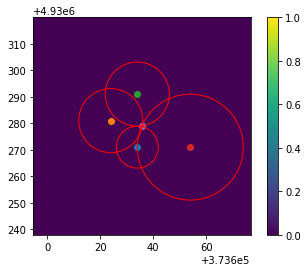

In [13]:
plt.imshow(heatMapArea, extent=[refX,maxX,minY,refY], origin='lower')
for pingNum in range(len(pings)):
    plt.scatter(pings[pingNum,0], pings[pingNum,1])
    nominalDistance = RSSItoDistance(P_rx[pingNum], P_tx, n_tx, alt=pings[pingNum,2])
    circ = Circle((pings[pingNum,0], pings[pingNum,1]), nominalDistance, fill=False, color='r')
    plt.gca().add_patch(circ)
plt.scatter(l_tx[0], l_tx[1])
plt.colorbar()

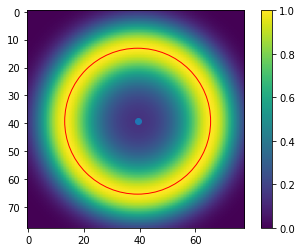

In [14]:
P_rx = 28
P_tx = 60
L_sigma = 5
n_tx = 2
alt = 30
nominalDistance = RSSItoDistance(P_rx, P_tx, n_tx, alt)
rx_location = np.array([nominalDistance * 1.5, nominalDistance * 1.5, 30])
heatMapArea = np.zeros((int(nominalDistance * 3), int(nominalDistance * 3)))
for x in range(int(nominalDistance * 3)):
    for y in range(int(nominalDistance * 3)):
        heatMapArea[y, x] = p_d(np.array([x, y, 0]), rx_location, n_tx, P_rx, P_tx, L_sigma)
plt.imshow(heatMapArea)
plt.scatter(rx_location[0], rx_location[1])
circ = Circle((rx_location[0], rx_location[1]), nominalDistance, fill=False, color='r')
plt.gca().add_patch(circ)
plt.colorbar()